In [1]:
%pip install rdkit
%pip install MDAnalysis
%cd /content/drive/MyDrive/Github/Fructose_in_water_MD_simulation/

/content/drive/MyDrive/Github/Fructose_in_water_MD_simulation


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
import time
from MDAnalysis.analysis import pca, align
import math
import seaborn as sns
import MDAnalysis.analysis.rms as rms
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import plotly.express as px
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors, AllChem, Draw, rdFMCS
from sklearn.model_selection import train_test_split
import copy
import itertools
import tensorflow as tf

In [4]:
# Creating a universe object from MD trajectory output files
top_file = "../../ML_datasets/Fructose_in_water_MD_simulation/topol.tpr"
traj_file = "../../ML_datasets/Fructose_in_water_MD_simulation/traj.trr"
u1 = mda.Universe(top_file, traj_file)

In [5]:
# extracting energy and temperature
ener_file = "../../ML_datasets/Fructose_in_water_MD_simulation/gmx_energy.xvg"
ener = np.loadtxt(fname = ener_file, skiprows=29, usecols=1)
temp = np.loadtxt(fname = ener_file, skiprows=29, usecols=2)

In [29]:
# aligning each frame of trajectory to first frame (look later)

In [6]:
# defining residues
fru = u1.select_atoms("resname FRU")
wat = u1.select_atoms("resname WAT")

In [7]:
# Applying PCA to find principal components
fru_pc = pca.PCA(u1, select = "resname FRU").run()

In [8]:
# Find all principal components whose cummulative variance ~ 0.99
fru_p_comp = fru_pc.results.p_components
n_pcs = np.where(fru_pc.results.cumulated_variance > 0.99)[0][0]

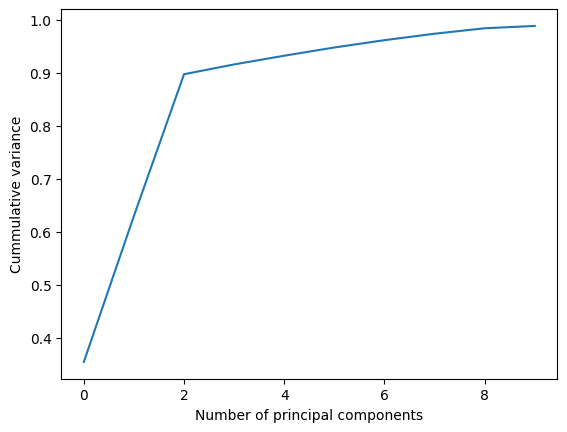

In [9]:
# plotting cummulative variance of n_pcs
plt.plot(fru_pc.results.cumulated_variance[:n_pcs])
plt.xlabel("Number of principal components")
plt.ylabel("Cummulative variance")
plt.show()

In [10]:
# Transforming into reduced space of n_pcs
fru_pc_reduced = fru_pc.transform(fru, n_components = n_pcs)

In [11]:
# Making a Pandas dataframe
df = pd.DataFrame(fru_pc_reduced, columns = ["PC{}".format(i+1) for i in range(n_pcs)])
df["Time (ps)"] = u1.trajectory.dt * df.index

In [12]:
df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Time (ps)
0,14.673906,21.623833,5.657903,6.329507,0.232876,0.645363,-8.315800,0.267554,6.315467,2.206139,0.0
1,12.421385,23.336048,1.240976,5.731294,0.518292,-1.448910,-6.545617,2.288346,7.726125,2.813133,1.0
2,10.645819,20.678829,5.413118,3.475926,3.512713,-0.730657,-4.766883,1.456655,8.587037,2.216062,2.0
3,10.712614,21.065348,4.910368,5.148092,2.520755,-1.464944,-5.656247,2.028285,8.015888,2.707769,3.0
4,11.735998,21.334394,3.821103,4.532218,2.229219,-4.755846,-5.048517,-0.005373,7.398762,2.400641,4.0


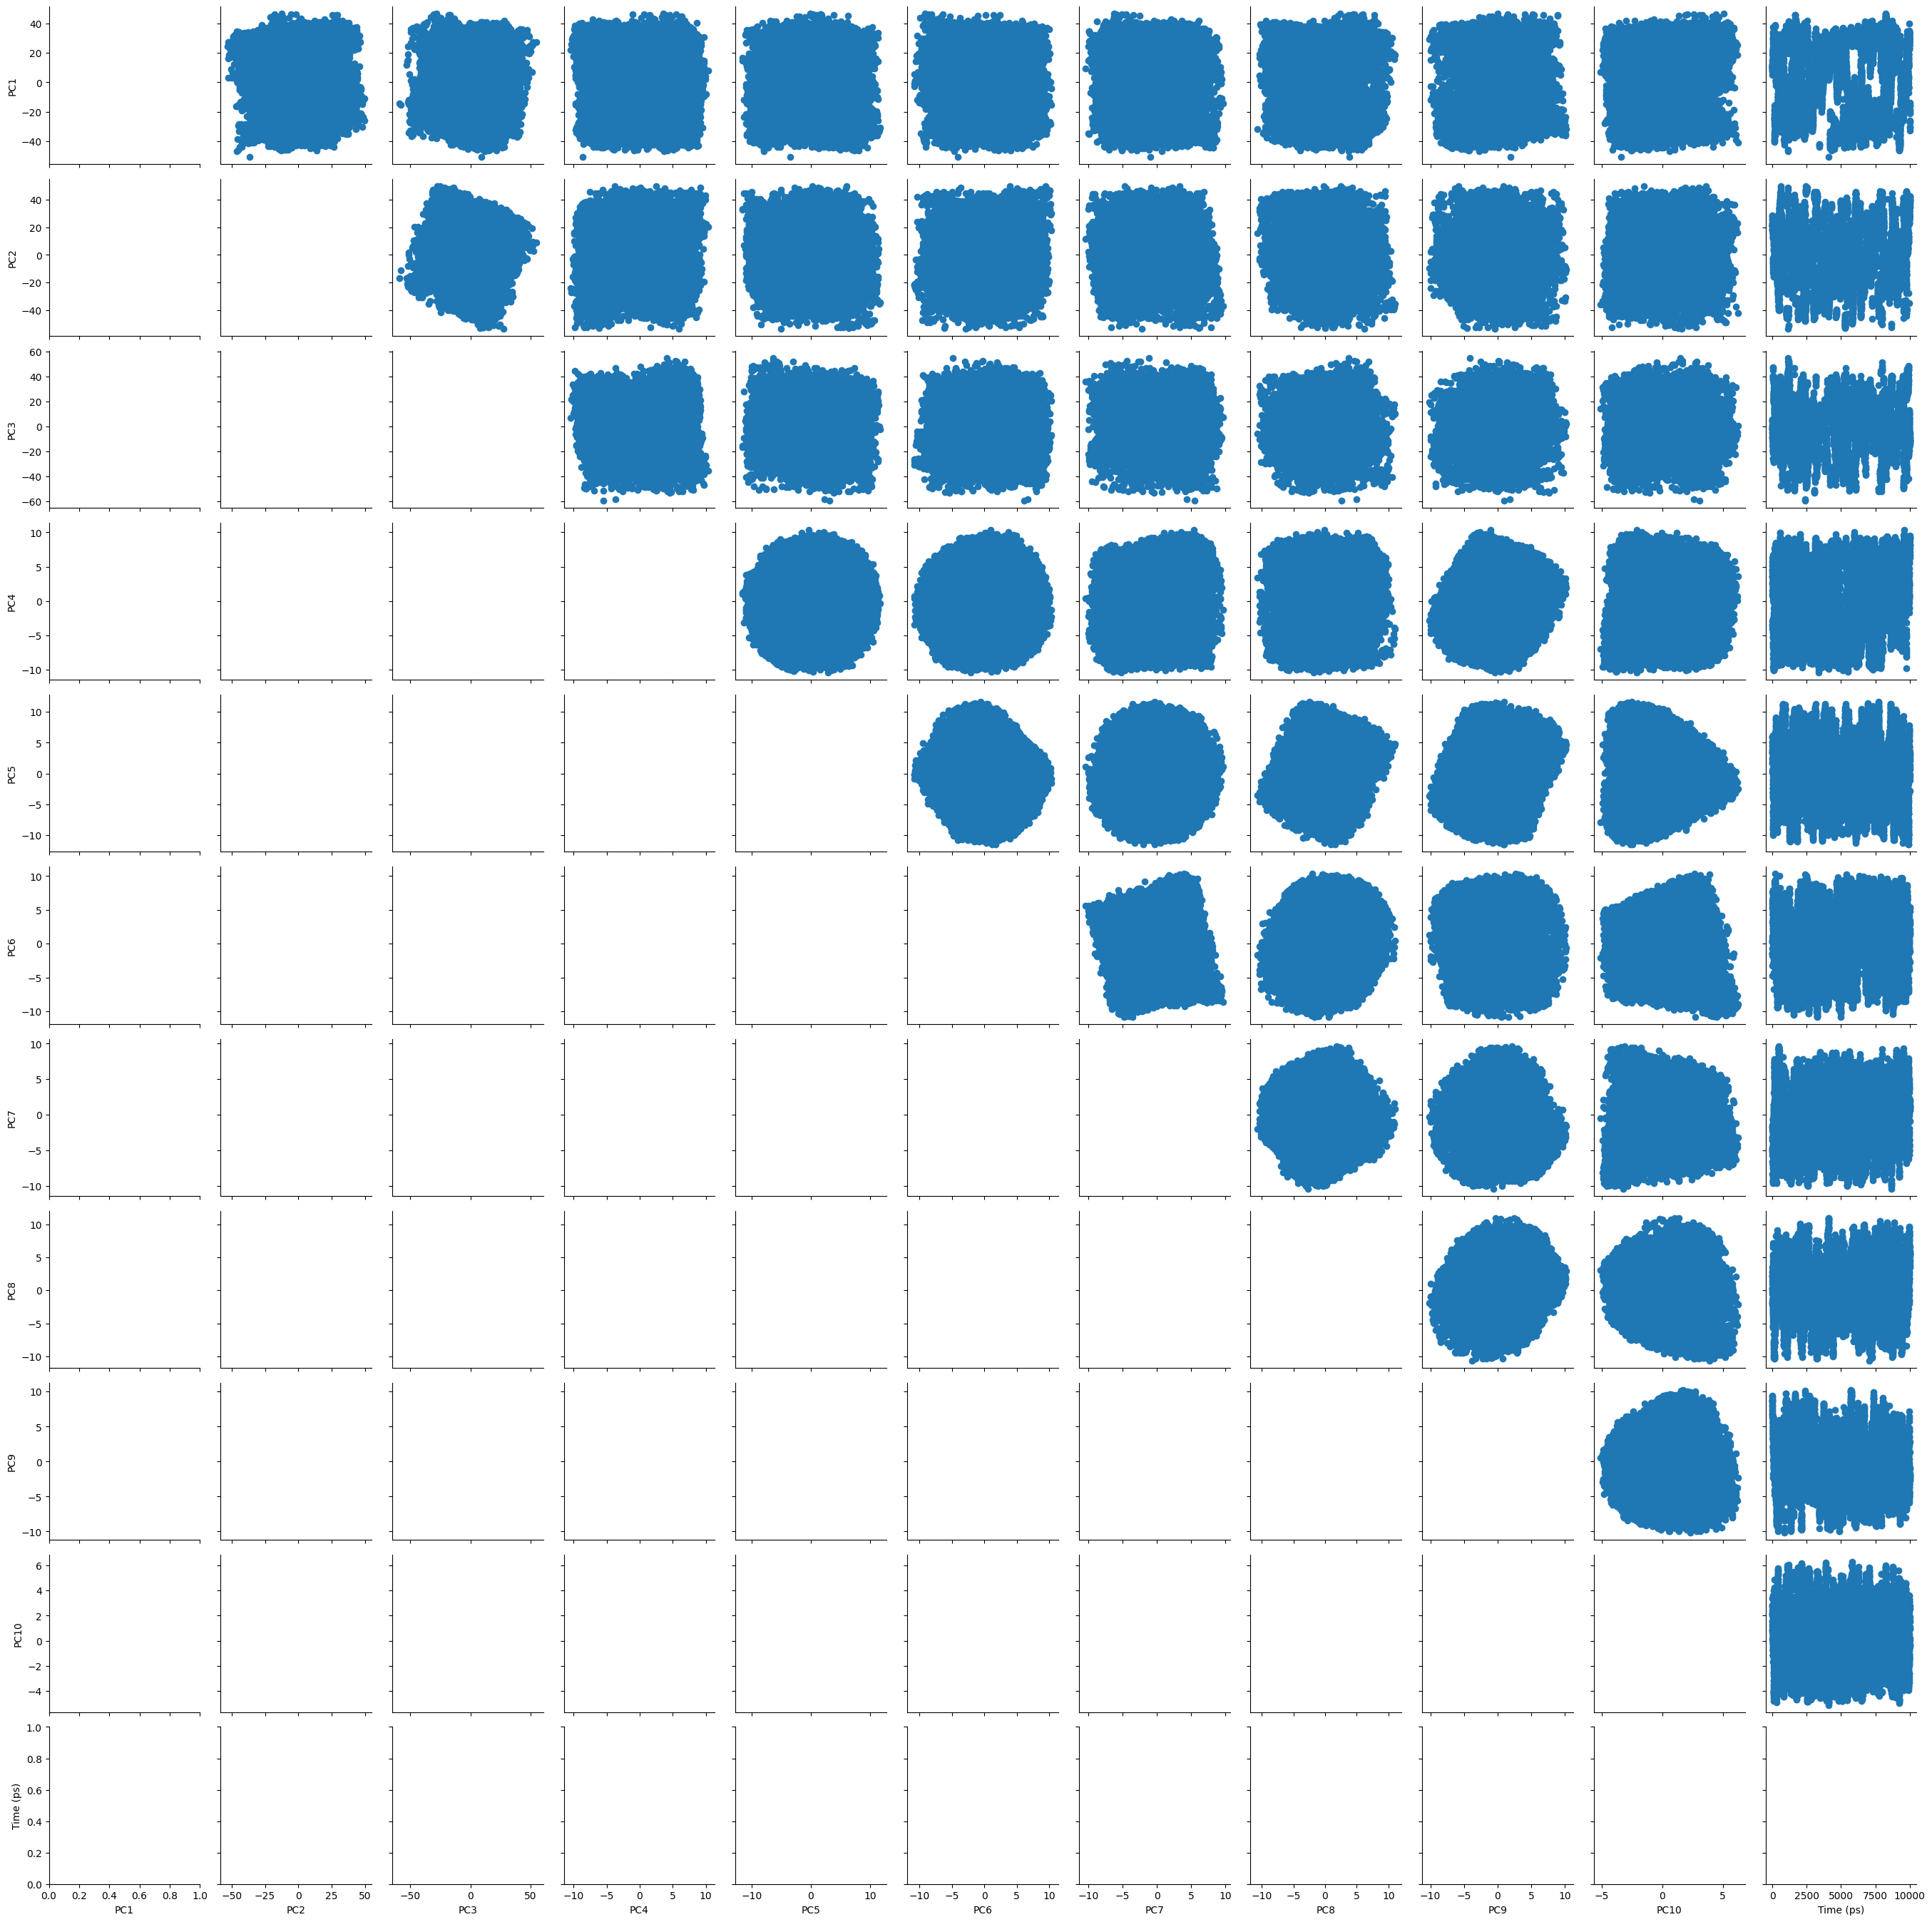

In [20]:
# Visualizing the principal components using seaborn's PairGrid
g = sns.PairGrid(df, diag_sharey=False)
g.map_upper(plt.scatter)
plt.show()

In [21]:
# Measuring convergence with cosine content
cos_content = [pca.cosine_content(fru_pc_reduced, i) for i in range(n_pcs)]

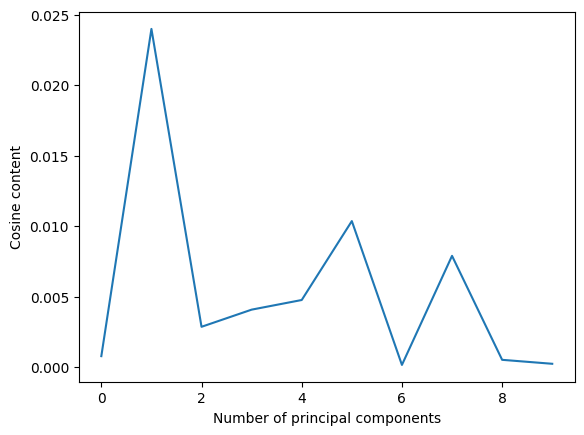

In [22]:
# Plotting the cosine content of each principal components
plt.plot(cos_content)
plt.xlabel("Number of principal components")
plt.ylabel("Cosine content")
plt.show()

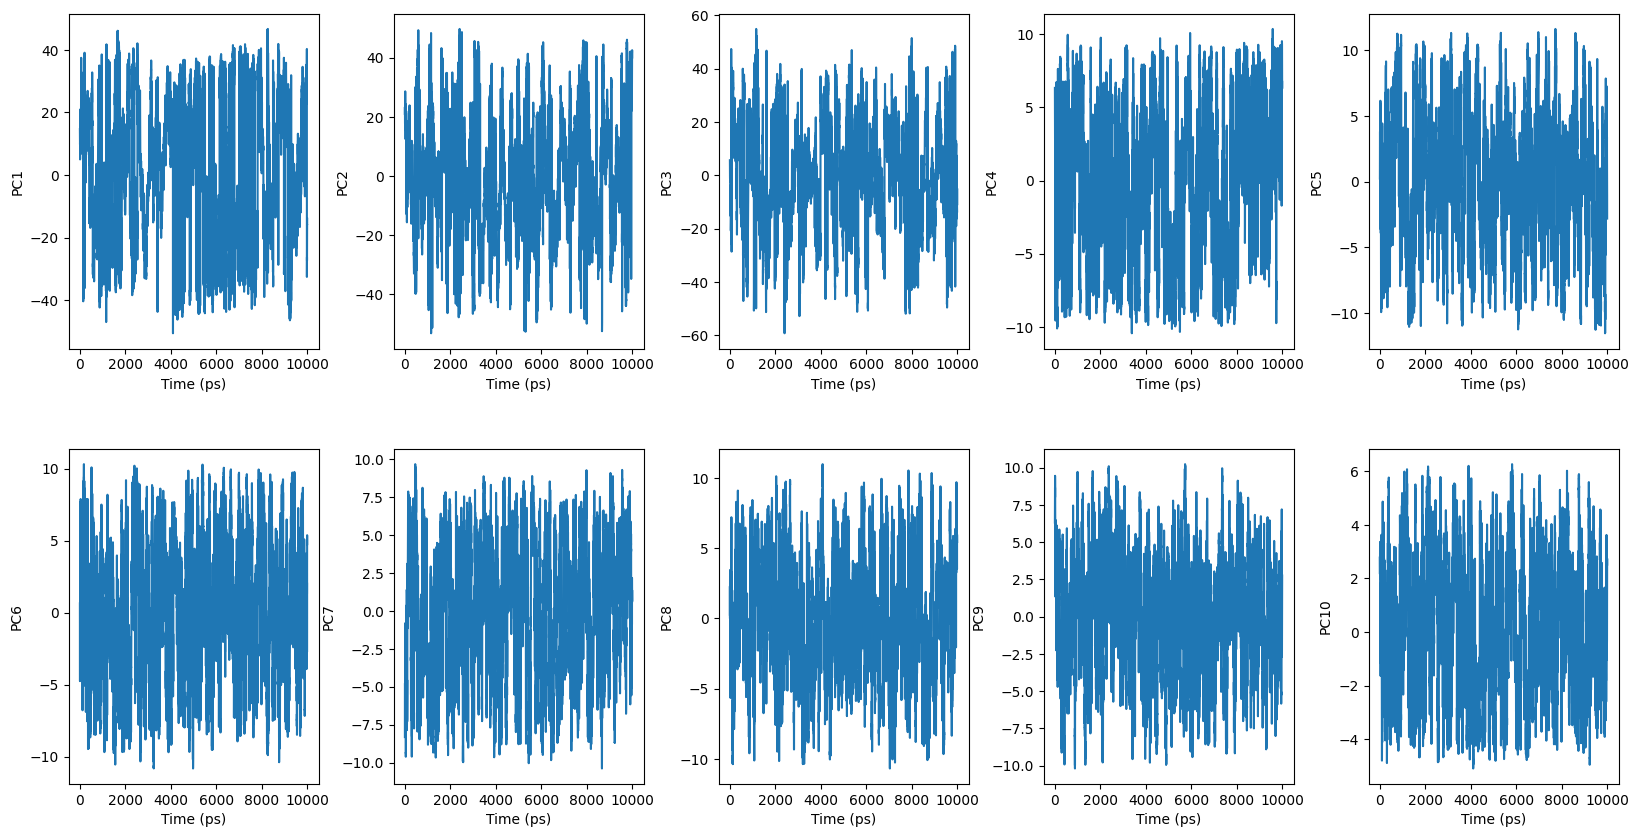

In [31]:
# Plotting transformed components (fru_pc_reduced) over time in different (2 x 5) plots (set both x and y labels and ensure appropriate spacing between plots)
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(10):
    axs[i//5, i%5].plot(df["Time (ps)"], fru_pc_reduced[:, i])
    axs[i//5, i%5].set_xlabel("Time (ps)")
    axs[i//5, i%5].set_ylabel("PC{}".format(i+1))
plt.show()